In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline


In [51]:
seeds = pd.read_csv('seeds_dataset.txt', sep = '\t', header = None, error_bad_lines=False)

In [52]:
seeds.describe()

,0,1,2,3,4,5,6,7
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [53]:
seeds.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 1. Run the clustering algorithms on the data sets and describe what you see.

### K-means clustering

In [61]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [64]:
# seperate the feature from target
seeds_data = seeds.iloc[:, :-1]
seeds_target = seeds.iloc[:, -1]
n_samples, n_features = seeds_data.shape
# get the number of types of seeds
n_types = len(np.unique(seeds_target))


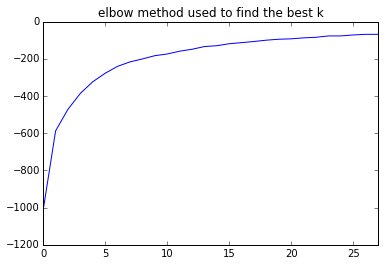

In [266]:
# use "elbow method" to find the best k
# kmeans score returns the opposite of the sum of inter-cluster distances, the sum of inter-cluster distances is what k-means tries to minimize
scores = []
for i in range(2, 30):
    kmeans_model = KMeans(n_clusters=i, random_state=1)
    kmeans_model.fit(seeds_data)
    score = kmeans_model.score(seeds_data)
    scores.append(score)
    
#print scores
pd.Series(scores).plot()
plt.title("elbow method used to find the best k")



In [267]:
kmeans_model = KMeans(n_clusters=3, random_state=1)
kmeans_model.fit(seeds_data)
seeds_labels = kmeans_model.labels_
#random_state = 170
#target_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(data)

seeds_expected = seeds_target
seeds_predicted = kmeans_model.predict(seeds_data)
print(metrics.classification_report(seeds_expected, seeds_predicted))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.12      0.13      0.12        70
          2       0.14      0.14      0.14        70
          3       0.00      0.00      0.00        70

avg / total       0.09      0.09      0.09       210



The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [268]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(seeds_predicted, seeds_expected)

0.7166198557361053

In [269]:
print(metrics.classification_report(seeds_expected, seeds_predicted))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.12      0.13      0.12        70
          2       0.14      0.14      0.14        70
          3       0.00      0.00      0.00        70

avg / total       0.09      0.09      0.09       210



In [270]:
print(metrics.confusion_matrix(seeds_expected, seeds_predicted))
print pd.Series(seeds_labels).value_counts()

[[ 0  0  0  0]
 [ 1  9 60  0]
 [60  0 10  0]
 [ 0 68  2  0]]
1    77
2    72
0    61
dtype: int64


In [271]:
print "the percentage of correctly classified labels: {}".format((60 + 60 + 68) / 210.0)

the percentage of correctly classified labels: 0.895238095238


### Expectation Maximization

In [272]:
from sklearn import mixture

gmm = mixture.GMM(n_components=3, covariance_type='tied')
gmm.fit(seeds_data)

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [273]:
seeds_predicted = gmm.predict(seeds_data)
print(metrics.confusion_matrix(seeds_expected, seeds_predicted))

[[ 0  0  0  0]
 [66  1  3  0]
 [ 1 69  0  0]
 [ 2  0 68  0]]


In [274]:
gmm.score(seeds_data);

In [275]:
adjusted_rand_score(seeds_predicted, seeds_expected)

0.9026431589942381

In [258]:
print "the percentage of correctly classified labels: {}".format((66 + 69 + 68) / 210.0)

the percentage of correctly classified labels: 0.966666666667


In [170]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(seeds_data)
        bic.append(gmm.bic(seeds_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [173]:
best_gmm

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

## 2. Apply the dimensionality reduction algorithms to the two datasets and describe what you see.

### PCA model 

In [68]:
from sklearn.decomposition import PCA

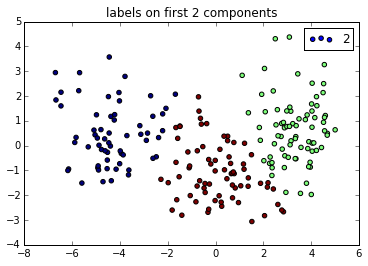

In [248]:
#If we chose first two componen, we can see both first two components seperate the clusters pretty well
#Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(seeds_data)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=seeds_labels)
plt.legend(seeds_labels, loc = 'best')
plt.title("labels on first 2 components")
# Show the plot.
plt.show()

In [265]:
pca = PCA(n_components = 2)
pca.fit(seeds_data)
fitted_data_pca = pca.fit_transform(seeds_data)
fitted_data_pca.shape

(210, 2)

In [115]:

pca = PCA(n_components = 7)
pca.fit(seeds_data)
print pca.explained_variance_ratio_
variance_explained = pca.explained_variance_ratio_
variance_explained = pd.Series(variance_explained)

[  8.29385197e-01   1.63632452e-01   5.65790880e-03   9.90306086e-04
   2.11180347e-04   1.20677139e-04   2.27879552e-06]


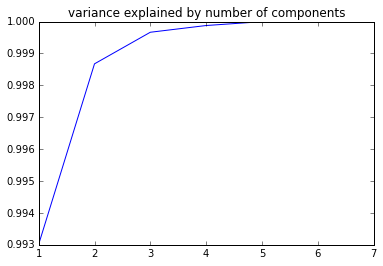

In [137]:
components = pd.Series(range(1, 8))
ve =pd.Series(variance_explained.cumsum(), index=pd.Series(range(1, 8)))
ve.plot()
plt.title("variance explained by number of components")

### ICA

In [141]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis



In [142]:
ica = FastICA(n_components = 3, whiten = True)
ica.fit(seeds_data)
print ica.get_params()

{'fun_args': None, 'algorithm': 'parallel', 'max_iter': 200, 'random_state': None, 'n_components': 3, 'tol': 0.0001, 'fun': 'logcosh', 'w_init': None, 'whiten': True}


In [182]:
ica = FastICA(n_components = None, whiten = True)
ica.fit(seeds_data)
print ica.get_params()

{'fun_args': None, 'algorithm': 'parallel', 'max_iter': 200, 'random_state': None, 'n_components': None, 'tol': 0.0001, 'fun': 'logcosh', 'w_init': None, 'whiten': True}


/Applications/anaconda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [144]:
output = ica.fit_transform(seeds_data)
kurt = kurtosis(output)
kurt

array([-0.44426541,  0.88763699, -1.14058577])

In [197]:
ica = FastICA(whiten = True)
fitted_data_ica = ica.fit_transform(seeds_data)
fitted_data_ica.shape

(210, 7)

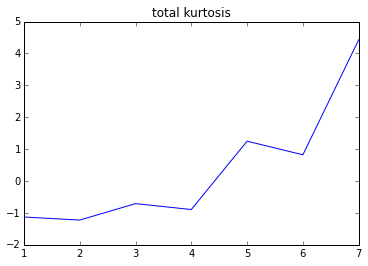

In [249]:
kurt_score = []
for i in range(1, 8):
    
    ica = FastICA(n_components = i, whiten = True)
    fitted_data_ica = ica.fit_transform(seeds_data)
    kurt = kurtosis(fitted_data_ica)
    kurt_score.append(np.sum(kurt))
    #print 'i: {}, total_kurtosis: {}'.format(i, np.sum(kurt))
    
kurt_score = pd.Series(kurt_score, index=pd.Series(range(1, 8)))
kurt_score.plot()
plt.title("total kurtosis")

### Random Projection

In [191]:
from sklearn import random_projection



In [261]:
eps_range = np.linspace(0.01, 0.99, 10)
for i in eps_range:
    try:
        rp = random_projection.GaussianRandomProjection(eps = i)
        fitted_data_rp =rp.fit_transform(seeds_data)
        print "eps: {}, the features after reduced dimension: {}".format(i, fitted_data_rp)
    except ValueError:
        print 'eps: {}, value error'.format(i)


eps: 0.01, value error
eps: 0.118888888889, value error
eps: 0.227777777778, value error
eps: 0.336666666667, value error
eps: 0.445555555556, value error
eps: 0.554444444444, value error
eps: 0.663333333333, value error
eps: 0.772222222222, value error
eps: 0.881111111111, value error
eps: 0.99, value error


In [193]:
from sklearn import random_projection
eps_range = np.linspace(0.01, 0.99, 10)
for i in eps_range:
    try:
        rp = random_projection.SparseRandomProjection(eps = i)
        fitted_data_rp =rp.fit_transform(seeds_data)
        print "eps: {}, the features after reduced dimension: {}".format(i, fitted_data_rp)
    except ValueError:
        print 'eps: {}, value error'.format(i)



eps: 0.01, value error
eps: 0.118888888889, value error
eps: 0.227777777778, value error
eps: 0.336666666667, value error
eps: 0.445555555556, value error
eps: 0.554444444444, value error
eps: 0.663333333333, value error
eps: 0.772222222222, value error
eps: 0.881111111111, value error
eps: 0.99, value error


### Tree based model selection

In [198]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(seeds_data, seeds_target)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
fitted_data_tb = model.transform(seeds_data)
fitted_data_tb.shape 

(210, 3)

## 3. Reproduce your clustering experiments, but on the data after you've run dimensionality reduction on it.

### data -> PCA -> kmeans clustering

transform data with PCA, then fit into kmeans 

In [278]:
kmeans_model.fit(fitted_data_pca)
#labels = kmeans_model.labels_

expected = target
predicted_pca = kmeans_model.predict(fitted_data_pca)
print(metrics.classification_report(expected, predicted_pca))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_pca), 4))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.12      0.13      0.12        70
          2       0.14      0.14      0.14        70
          3       0.00      0.00      0.00        70

avg / total       0.09      0.09      0.09       210

adjusted rand score: 0.7166


In [279]:
print(metrics.confusion_matrix(seeds_expected, predicted_pca))


[[ 0  0  0  0]
 [ 1  9 60  0]
 [60  0 10  0]
 [ 0 68  2  0]]


In [280]:
print "the percentage of correctly classified labels: {}".format((60 + 60 + 68) / 210.0)

the percentage of correctly classified labels: 0.895238095238


### data -> ICA -> kmeans clustering

In [277]:
#kmeans_model = KMeans(n_clusters=12, random_state=1)
kmeans_model.fit(fitted_data_ica)
#labels = kmeans_model.labels_

expected = target
predicted_ica = kmeans_model.predict(fitted_data_ica)
print(metrics.classification_report(expected, predicted_ica))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_ica), 4))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.01      0.01      0.01        70
          2       0.00      0.00      0.00        70
          3       0.00      0.00      0.00        70

avg / total       0.00      0.00      0.00       210

adjusted rand score: 0.8778


In [281]:
print(metrics.confusion_matrix(seeds_expected, predicted_ica))


[[ 0  0  0  0]
 [ 2  1 67  0]
 [ 0 70  0  0]
 [64  0  6  0]]


In [282]:
print "the percentage of correctly classified labels: {}".format((67 + 70 + 64) / 210.0)

the percentage of correctly classified labels: 0.957142857143


### data -> tree based feature selection -> kmeans clustering¶

In [203]:
#kmeans_model = KMeans(n_clusters=12, random_state=1)
kmeans_model.fit(fitted_data_tb)
#labels = kmeans_model.labels_

expected = target
predicted_tb = kmeans_model.predict(fitted_data_tb)
print(metrics.classification_report(expected, predicted_tb))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_tb), 4))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.20      0.24      0.22        70
          2       1.00      0.79      0.88        70
          3       0.00      0.00      0.00        70

avg / total       0.40      0.34      0.37       210

adjusted rand score: 0.6211


In [283]:
print(metrics.confusion_matrix(seeds_expected, predicted_tb))

[[ 0  0  0  0]
 [53 17  0  0]
 [15  0 55  0]
 [ 0 70  0  0]]


In [284]:
print "the percentage of correctly classified labels: {}".format((53 + 55 + 70) / 210.0)

the percentage of correctly classified labels: 0.847619047619


### data -> PCA -> Expectation Maximization clustering¶

In [205]:
gmm = mixture.GMM(n_components = 3, covariance_type="tied")

gmm.fit(fitted_data_pca)

predicted_gmm_pca = gmm.predict(fitted_data_pca)
print(metrics.classification_report(expected, predicted_gmm_pca))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_gmm_pca), 4))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.02      0.01      0.02        70
          2       0.16      0.16      0.16        70
          3       0.00      0.00      0.00        70

avg / total       0.06      0.06      0.06       210

adjusted rand score: 0.6996


In [285]:
print(metrics.confusion_matrix(seeds_expected, predicted_gmm_pca))

[[ 0  0  0  0]
 [12  1 57  0]
 [ 0 59 11  0]
 [70  0  0  0]]


In [286]:
print "the percentage of correctly classified labels: {}".format((70 + 59 + 57) / 210.0)

the percentage of correctly classified labels: 0.885714285714


### data -> ICA -> Expectation Maximization clustering¶

In [206]:
gmm.fit(fitted_data_ica)

predicted_gmm_ica = gmm.predict(fitted_data_ica)
print(metrics.classification_report(expected, predicted_gmm_ica))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_gmm_ica), 4))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.05      0.04      0.04        70
          2       0.03      0.03      0.03        70
          3       0.00      0.00      0.00        70

avg / total       0.02      0.02      0.02       210

adjusted rand score: 0.7997


In [287]:
print(metrics.confusion_matrix(seeds_expected, predicted_gmm_ica))

[[ 0  0  0  0]
 [ 1  3 66  0]
 [68  0  2  0]
 [ 0 61  9  0]]


In [288]:
print "the percentage of correctly classified labels: {}".format((68 + 61 + 66) / 210.0)

the percentage of correctly classified labels: 0.928571428571


### data -> tree based feature selection -> Expectation Maximization clustering

In [210]:
gmm.fit(fitted_data_tb)

predicted_gmm_tb = gmm.predict(fitted_data_tb)
print(metrics.classification_report(expected, predicted_gmm_tb))

print "adjusted rand score: {}".format(round(adjusted_rand_score(expected, predicted_gmm_tb), 4))


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.07      0.07      0.07        70
          2       0.03      0.03      0.03        70
          3       0.00      0.00      0.00        70

avg / total       0.03      0.03      0.03       210

adjusted rand score: 0.8633


In [289]:
print(metrics.confusion_matrix(seeds_expected, predicted_gmm_tb))

[[ 0  0  0  0]
 [ 2  5 63  0]
 [68  0  2  0]
 [ 0 69  1  0]]


In [290]:
print "the percentage of correctly classified labels: {}".format((68 + 69 + 63) / 210.0)

the percentage of correctly classified labels: 0.952380952381


** adjusted rand score for different algorithms ** 


| algo | Kmeans |   EM      |
|------|--------|-----------|
|Base| 0.7166|0.8296|
|PCA| 0.7166|0.6996|
|ICA| 0.8778|0.7997|
|TREE|0.6211|0.8633|



In [291]:
pwd

u'/Users/craiglab/Documents/ml/Assignment3'